Scale Thresholding, Applying Filters, Transformations, Segmentation

The training set is used to fit the models; the validation set is used to estimate prediction error for model selection; the test set is used for assessment of the generalization error of the final chosen model. Ideally, the test set should be kept in a “vault,” and be brought out only at the end of the data analysis.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [2]:
#from PyTorch transfer learning tutorial nb
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
from pathlib import Path

In [4]:
data_dir = Path('../data/chest_xray')
train_dir = data_dir / 'train'
test_dir = data_dir / 'test'
val_dir = data_dir / 'val'

# Training Data

To begin, we need to load the images in our training set. Essentially, we will make a list of paths to each image, and then use a separate function later to read the image file. 

I found these resources to be very helpful for learning how to load in image data

        https://docs.python.org/3/library/glob.html
        https://www.kaggle.com/code/aakashnain/beating-everything-with-depthwise-convolution

In [5]:
normal_path = train_dir / 'NORMAL'
pneumo_path = train_dir / 'PNEUMONIA'

#lists of the images
normal = normal_path.glob('*jpeg')
pneumo = pneumo_path.glob('*jpeg')

# we will store the normal images with a 0, pneumo with a 1
train = []
for x in normal:
    train.append((x,0))
for y in pneumo:
    train.append((y,1))

In [23]:
#lets take a look at this
train[:3]

[(WindowsPath('../data/chest_xray/train/NORMAL/IM-0115-0001.jpeg'), 0),
 (WindowsPath('../data/chest_xray/train/NORMAL/IM-0117-0001.jpeg'), 0),
 (WindowsPath('../data/chest_xray/train/NORMAL/IM-0119-0001.jpeg'), 0)]

In [24]:
train[-3:]

[(WindowsPath('../data/chest_xray/train/PNEUMONIA/person9_bacteria_39.jpeg'),
  1),
 (WindowsPath('../data/chest_xray/train/PNEUMONIA/person9_bacteria_40.jpeg'),
  1),
 (WindowsPath('../data/chest_xray/train/PNEUMONIA/person9_bacteria_41.jpeg'),
  1)]

This looks like what we wanted, a single list with the paths to the normal images at the beginning, and pnemo images at the end. 

In [8]:
#create a pandas dataframe from this list
trainDF = pd.DataFrame(train, columns = ['image','label'],index = None)

In [9]:
trainDF.head()

,image,label
0,..\data\chest_xray\train\NORMAL\IM-0115-0001.jpeg,0
1,..\data\chest_xray\train\NORMAL\IM-0117-0001.jpeg,0
2,..\data\chest_xray\train\NORMAL\IM-0119-0001.jpeg,0
3,..\data\chest_xray\train\NORMAL\IM-0122-0001.jpeg,0
4,..\data\chest_xray\train\NORMAL\IM-0125-0001.jpeg,0


In [10]:
trainDF.tail()

,image,label
5211,..\data\chest_xray\train\PNEUMONIA\person99_vi...,1
5212,..\data\chest_xray\train\PNEUMONIA\person9_bac...,1
5213,..\data\chest_xray\train\PNEUMONIA\person9_bac...,1
5214,..\data\chest_xray\train\PNEUMONIA\person9_bac...,1
5215,..\data\chest_xray\train\PNEUMONIA\person9_bac...,1


In [11]:
 trainDF.label.value_counts()

1    3875
0    1341
Name: label, dtype: int64

So, in our training data, we have 3875 images where the patient has pneumonia, and 1341 where the person is normal. 

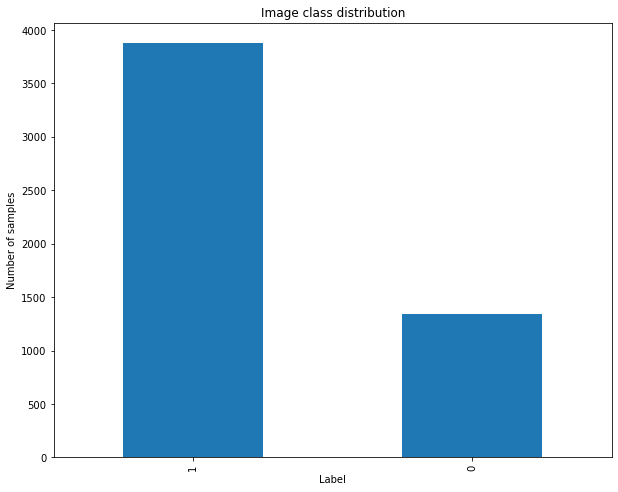

In [12]:
plt.figure(figsize = (10,8))
trainDF.label.value_counts().plot(kind = 'bar')
plt.xlabel('Label')
plt.ylabel('Number of samples')
plt.title('Image class distribution')
plt.show()

    https://www.kaggle.com/code/homayoonkhadivi/medical-diagnosis-with-cnn-transfer-learning

# Images in our training set

Here are 5 pictures of X-Ray's that were diagnosed with pneumonia

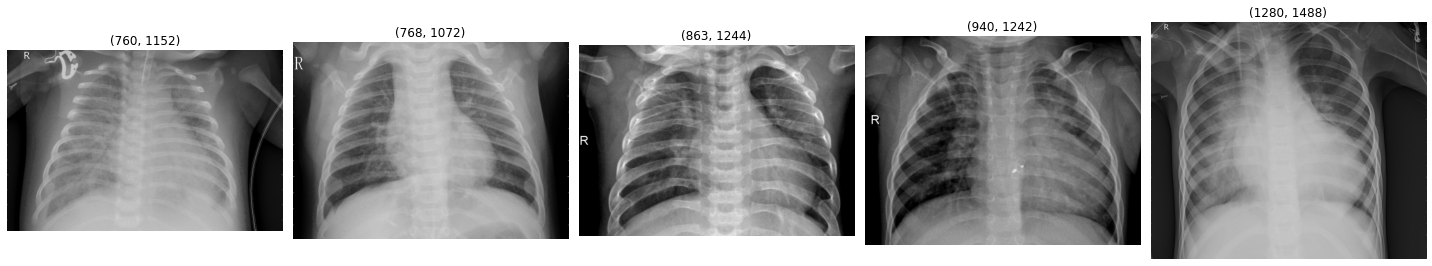

In [11]:

pneumo_pics = (trainDF[trainDF['label']==1]['image'].iloc[:5]).tolist()
#normal_pics = (trainDF[trainDF['label']==0]['image'].iloc[:5]).tolist()

plt.figure(figsize=(20, 10))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = plt.imread(pneumo_pics[i])
    #img = plt.imread(os.path(normal_path))
    plt.imshow(img, cmap='gray')
    plt.title("Pneumonia", img.shape)
    plt.axis('off')
    
plt.tight_layout()

And here are 5 pictures of X-Ray's that were diagnosed as normal.

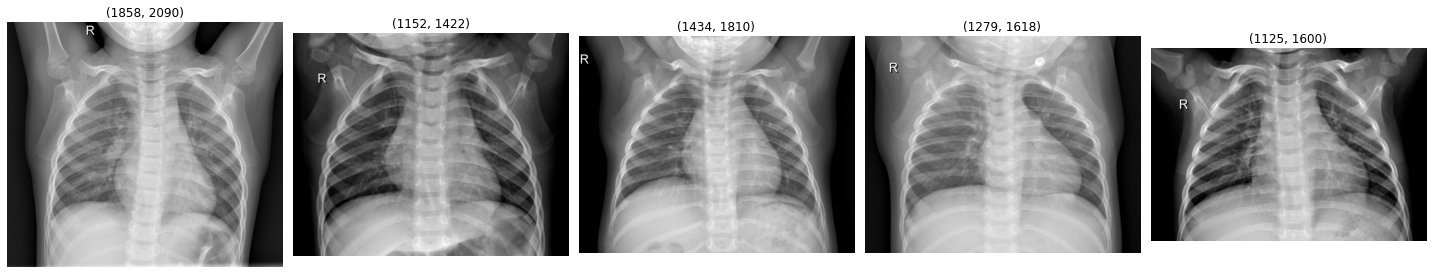

In [12]:
normal_pics = (trainDF[trainDF['label']==0]['image'].iloc[:5]).tolist()
plt.figure(figsize=(20, 10))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = plt.imread(normal_pics[i])
    #img = plt.imread(os.path(normal_path))
    plt.imshow(img, cmap='gray')
    plt.title(img.shape)
    plt.axis('off')
    
plt.tight_layout()

Lets take a look at a bigger version of a normal image, this time with the grayscale colorbar added

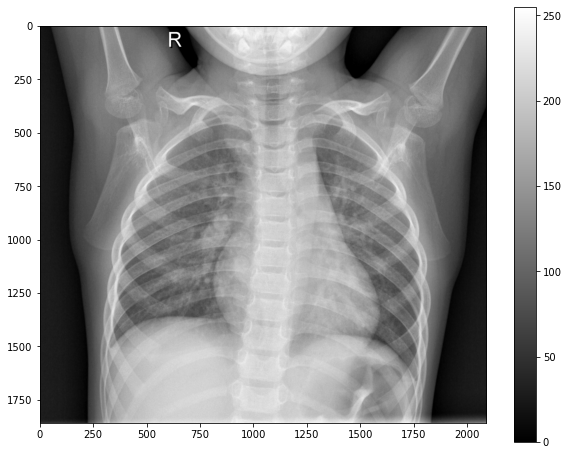

In [13]:
plt.figure(figsize = (10,8))
img = plt.imread(normal_pics[0])
plt.imshow(img,cmap='gray')
plt.colorbar()
plt.show()

In [14]:
img.shape

(1858, 2090)

# Data Transformations

In [17]:
# augmentation and normalization for training
# only normalization for test

# normalization coefficients come from imagenet data? I think

#add transforms.RandomRotation(10) ?
# trandoms.RandomHorizontalFlip(), Resize()
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [30]:
train_data = datasets.ImageFolder(train_dir, transform = data_transforms['train'])
test_data = datasets.ImageFolder(test_dir, transform = data_transforms['test'])

In [31]:
type(train_data)

torchvision.datasets.folder.ImageFolder

In [32]:
train_data.classes

['NORMAL', 'PNEUMONIA']

In [33]:
class_names = train_data.classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [34]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3060 Laptop GPU'

## DataLoader

In [35]:
trainDL = DataLoader(train_data, batch_size = 16, shuffle = True, num_workers = 4,pin_memory=True)

Lets take a look at what a single batch from our training data looks like

In [40]:
def imshow(inp, figsize = (20,20),title=None):
    """Imshow for Tensor.
    This function is modified from the PyTorch transfer learning tutorial notebook
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize = figsize)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


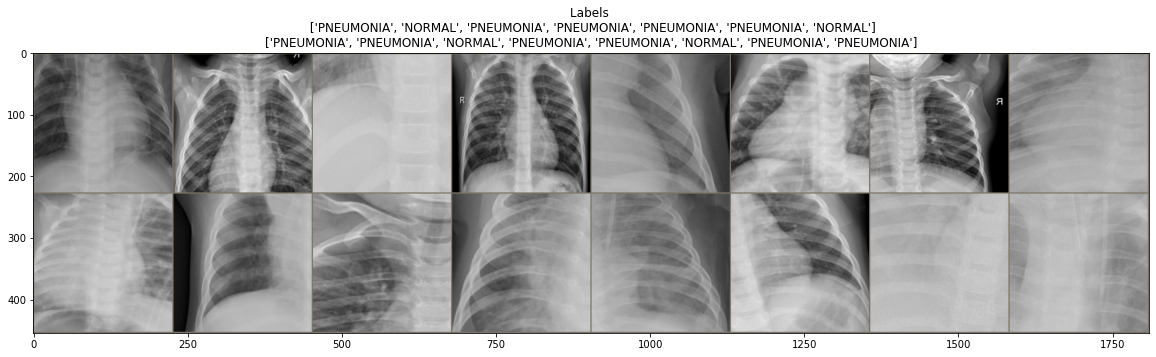

In [48]:
# Get a batch of training data
inputs, classes = next(iter(trainDL))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
#Split the title

batchnames = [class_names[x] for x in classes]

imshow(out, title = "Labels \n "+ str(batchnames[:7])+"\n"+str(batchnames[8:]))

In [46]:
str(batchnames)

"['PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA']"

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor.
    This function is from the PyTorch transfer learning tutorial notebook
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}

In [ ]:
#https://www.kaggle.com/code/arunrk7/covid-19-detection-pytorch-tutorial

#cool way to plot
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

AutoAugment is a common Data Augmentation technique that can improve the accuracy of Image Classification models. Though the data augmentation policies are directly linked to their trained dataset, empirical studies show that ImageNet policies provide significant improvements when applied to other datasets. In TorchVision we implemented 3 policies learned on the following datasets: ImageNet, CIFAR10 and SVHN. The new transform can be used standalone or mixed-and-matched with existing transforms:
    https://pytorch.org/vision/stable/transforms.html

    https://pytorch.org/vision/stable/feature_extraction.html

In [53]:
from torchvision.models.segmentation import fcn_resnet50
from torchvision.models.segmentation import FCN_ResNet50_Weights
#, FCN_ResNet50_Weights
#model = fcn_resnet50()
weights = FCN_ResNet50_Weights.DEFAULT
transforms = weights.transforms(resize_size=None)

model = fcn_resnet50(weights=weights, progress=False)
model = model.eval()

batch = torch.stack([transforms(d) for d in pnemo_pics[:5]])
output = model(batch)['out']
print(output.shape, output.min().item(), output.max().item())

ImportError: cannot import name 'FCN_ResNet50_Weights' from 'torchvision.models.segmentation' (C:\Users\alber\anaconda3\lib\site-packages\torchvision\models\segmentation\__init__.py)

https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html#sphx-glr-auto-examples-plot-visualization-utils-py

In [ ]:
# https://pyimagesearch.com/2021/10/04/image-data-loaders-in-pytorch/
# load all the image paths and randomly shuffle them
print("[INFO] loading image paths...")
imagePaths = list(paths.list_images(config.FLOWERS_DATASET_PATH))
np.random.shuffle(imagePaths)
# generate training and validation paths
valPathsLen = int(len(imagePaths) * config.VAL_SPLIT)
trainPathsLen = len(imagePaths) - valPathsLen
trainPaths = imagePaths[:trainPathsLen]
valPaths = imagePaths[trainPathsLen:]
# copy the training and validation images to their respective
# directories
print("[INFO] copying training and validation images...")
copy_images(trainPaths, config.TRAIN)
copy_images(valPaths, config.VAL)



def visualize_batch(batch, classes, dataset_type):
	# initialize a figure
	fig = plt.figure("{} batch".format(dataset_type),
		figsize=(config.BATCH_SIZE, config.BATCH_SIZE))
	# loop over the batch size
	for i in range(0, config.BATCH_SIZE):
		# create a subplot
		ax = plt.subplot(2, 4, i + 1)
		# grab the image, convert it from channels first ordering to
		# channels last ordering, and scale the raw pixel intensities
		# to the range [0, 255]
		image = batch[0][i].cpu().numpy()
		image = image.transpose((1, 2, 0))
		image = (image * 255.0).astype("uint8")
		# grab the label id and get the label from the classes list
		idx = batch[1][i]
		label = classes[idx]
		# show the image along with the label
		plt.imshow(image)
		plt.title(label)
		plt.axis("off")
	# show the plot
	plt.tight_layout()
	plt.show()
    
trainBatch = next(iter(trainDataLoader))
valBatch = next(iter(valDataLoader))
# visualize the training and validation set batches
print("[INFO] visualizing training and validation batch...")
visualize_batch(trainBatch, trainDataset.classes, "train")
visualize_batch(valBatch, valDataset.classes, "val")

In [ ]:
#https://www.kaggle.com/code/arunrk7/covid-19-detection-pytorch-tutorial
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
    
            for j in range(inputs.size()[0]):
                images_handeled += 1    
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], (5,5))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)